In [1]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net, SCVIZ_CheckNet2Net
import pickle5
from tqdm import tqdm 
from sklearn.neighbors import NearestNeighbors
from perturbnet.baselines.knn import *
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
some_path = ""
path_cinn_model = some_path + '/cinn_chemvae_5kgene_scvi/100ep/'
path_data = ""
path_chemvae_model = some_path + "/chemicalvae/zinc/model_params_525.pt"

#path_vae_model_eval = '/nfs/turbo/umms-welchjd/wzqian/model_save/sciplex_normalized_unadjust/PerturbNet/eval/model'
path_vae_model_train = some_path + '/cellvae/z10_scvi/model/'
path_chem_onehot = some_path + "/zinc/"

# Load Data and PerturbNet

In [3]:



adata = ad.read_h5ad(os.path.join(path_data, "sciplex_mix_standard_processed_nan_removed.h5ad"))
    
adata_save_index = np.array(adata.obs[adata.obs["good_smile_chemvae"] == 1]["indices"])
adata = adata[adata_save_index, :].copy() 
adata.obs["indices"] = list(range(adata.X.shape[0]))
print(adata.obs.shape)
    
    

    
cell_type = pd.get_dummies(adata.obs["cell_type"])[['A549', 'K562', 'MCF7']].to_numpy()
dose_time = adata.obs[["dose"]].to_numpy()
covariates_embedding = np.concatenate([cell_type,dose_time],axis=1)
    
adata_test_index = np.array(adata.obs[adata.obs["holdout_1"] == "test"]["indices"])
adata_test = adata[adata_test_index, :].copy()
covariates_embedding_test = covariates_embedding[adata_test_index,:] 
    
adata_train_index = np.array(adata.obs[adata.obs["holdout_1"] == "train"]["indices"])
adata_train = adata[adata_train_index, :].copy()
covariates_embedding_train = covariates_embedding[adata_train_index,:] 
data_chem_onehot = np.load(os.path.join(path_chem_onehot, "onehot_zinc.npy"))

usedata = adata_test.X.A
alldata = adata.X.A

perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["perturb_string_processed"]), np.array(adata_test.obs["perturb_string_processed"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    
## onehot
onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile_chemvae"] == trt)[0][0]
    onehot_unseen_idx.append(onehot_idx)
unseen_onehot = adata.uns["ordered_all_onehot_chemvae"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile_chemvae"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
seen_onehot = adata.uns["ordered_all_onehot_chemvae"][onehot_seen_idx]    
    
scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model_train = scvi.model.SCVI.load(path_vae_model_train , adata_train, use_cuda = False)


# (2) load models
 ## cellpainting vae
# Tensors
device = "cuda" if torch.cuda.is_available() else "cpu"


model_chemvae = ChemicalVAE(n_char = data_chem_onehot.shape[2],max_len = data_chem_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()

#std_model 
std_model = Standardize(data_all = data_chem_onehot, model = model_chemvae, device = device)


## cinn
perturbToOnehot = {}
for i in range(trt_unseen_list.shape[0]):
    perturbToOnehot[trt_unseen_list[i]] = i    
        
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 200,embedding_dim = 10, conditioning_depth = 2, n_flows = 20, 
                               in_channels = 10, hidden_dim = 1024, hidden_depth = 2, activation = "none", conditioner_use_bn = True)

model_c = Net2NetFlow_TFVAE_Covariate_Flow(configured_flow = flow_model, first_stage_data = usedata, cond_stage_data = perturb_with_onehot_removed,
                          perturbToOnehotLib = perturbToOnehot, oneHotData = unseen_onehot, model_con = model_chemvae, 
                          std_model = std_model,covariates = covariates_embedding, scvi_model = scvi_model_train)
model_c.to(device = device)
model_c.load(path_cinn_model)


model_c.eval()
scvi.data.setup_anndata(adata_test, layer = "counts")
scvi_model_train = scvi.model.SCVI.load(path_vae_model_train, adata_test, use_cuda = False)

Lsample_obs = scvi_model_train.get_latent_library_size(adata = adata_train, give_mean = False)


scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model_train = scvi.model.SCVI.load(path_vae_model_train, adata_train, use_cuda = False)

scvi_model_de = scvi_predictive_z(scvi_model_train)
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)

model_g = model_c.model_con
model_g.eval()

trt_pert_list = []
for i in trt_unseen_list:
    trt_pert_list.append(adata.obs[adata.obs["perturb_string_processed"] == i]["product_name_clean"].unique()[0])

trt_treatment_list = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    idx = np.where(adata_test.uns["ordered_all_smile_chemvae"] == trt)[0][0]
    trt_treatment_list.append(adata_test.uns["ordered_all_trt_chemvae"][idx])

if sparse.issparse(adata_test.X):
    usedata = adata_test.X.A
else:
    usedata = adata_test.X

if sparse.issparse(adata_test.layers["counts"]):
    usedata_count = adata_test.layers["counts"].A
else:
    usedata_count = adata_test.layers["counts"]




(608674, 62)
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 480283 cells, 5087 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch            

In [4]:
normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)




perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]

    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))
                                     
    _, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
    embdata_np = np.concatenate([embdata_np,covariates_embedding_test[idx_trt_type]],axis = 1)
    #Zsample_scvi_batch = Zsample_scvi[idx_trt_type,]
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), len(idx_trt_type), replace=True)
    library_trt_latent =Lsample_obs[Lsample_idx,]
    
    real_data_all = adata_test.layers["counts"][idx_trt_type].A
    
    _, fake_data_all = perturbnet_model.sample_data(embdata_np, library_trt_latent)
    
    r2_value, real_norm, rfake_norm = normModel.calculate_r_square(real_data_all, fake_data_all)
    pear_value = normModel.calculate_pearson(real_data_all, fake_data_all)

    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data_all[:,DEG_idx]
    fake_data_deg = fake_data_all[:,DEG_idx]


    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = normModel.calculate_pearson(real_data_deg, fake_data_deg)
   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data_all[:,large_effect_idx ]
        fake_data_large = fake_data_all[:,large_effect_idx ]
        r2_large_value,_ ,_  = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    treatment_list.append(treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 38/38 [03:22<00:00,  5.34s/it]


# Biolord

In [6]:
some_path = ""
fidscore_cal = fidscore()
pred_data_path  = some_path + "pred_dict.pkl"
with open(pred_data_path , "rb") as fh:
    pred_dict = pickle.load(fh)
pred_dict_pop = {}
for k,v in pred_dict.items():
    new_k = k.split("_")[1]
    if new_k in pred_dict_pop:
        pred_dict_pop[new_k] = np.concatenate((pred_dict_pop[new_k], v[2]))
    else:
        pred_dict_pop[new_k] = v[2]
        
perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    if pert == "Motesanib" or pert == "SNS-314":
        continue
    treatment = trt_treatment_list[indice_trt]
    
    
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    
    real_data_all = adata_test.layers["counts"][idx_trt_type].A
    
    fake_data_all = pred_dict_pop[pert]
    
    r2_value = fidscore_cal.calculate_r_square(real_data_all, fake_data_all)
    pear_value = fidscore_cal.calculate_pearson(real_data_all, fake_data_all)

    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data_all[:,DEG_idx]
    fake_data_deg = fake_data_all[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data_all[:,large_effect_idx ]
        fake_data_large = fake_data_all[:,large_effect_idx ]
        r2_large_value  = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = fidscore_cal.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    treatment_list.append(treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_Biolord = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


# Training Sample

In [7]:

perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
seen_data = adata_train.layers["counts"].A
seen_data_idx = list(range(seen_data.shape[0]))

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    
    
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    
    real_data_all = adata_test.layers["counts"][idx_trt_type].A
    idx_rsample = np.random.choice(seen_data_idx, 1000, replace=True)
    
    fake_data_all = seen_data[idx_rsample]
    norm_vec_real = adata[idx_trt_type, :].obs["n_counts_total"].to_numpy()
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_rsample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data_all, fake_data_all,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data_all, fake_data_all,norm_vec_real,norm_vec_fake)

    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data_all[:,DEG_idx]
    fake_data_deg = fake_data_all[:,DEG_idx]


    r2_deg_value = normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data_all[:,large_effect_idx ]
        fake_data_large = fake_data_all[:,large_effect_idx ]
        r2_large_value  = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        

    perturb.append(pert)
    treatment_list.append(treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)



results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 38/38 [00:33<00:00,  1.15it/s]


# KNN

In [9]:
_, _, _, embdata_torch_seen = model_chemvae(torch.tensor(seen_onehot).float().to(device))
embdata_numpy_seen = std_model.standardize_z(embdata_torch_seen.cpu().detach().numpy())
_, _, _, embdata_torch_unseen = model_chemvae(torch.tensor(unseen_onehot).float().to(device))
embdata_numpy_unseen = std_model.standardize_z(embdata_torch_unseen.cpu().detach().numpy())

neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(embdata_numpy_seen)

perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
seen_data = adata_train.layers["counts"].A
seen_data_idx = list(range(seen_data.shape[0]))

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    
    
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    
    
    
    real_data_all = adata_test.layers["counts"][idx_trt_type].A
    
    distances, other_trts = neigh_fit.kneighbors(embdata_numpy_unseen[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(idx_trt_type))
    
    fake_data_all = seen_data[idx_sample]
    norm_vec_real = adata[idx_trt_type, :].obs["n_counts_total"].to_numpy()
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_sample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data_all, fake_data_all,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data_all, fake_data_all,norm_vec_real,norm_vec_fake)
    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data_all[:,DEG_idx]
    fake_data_deg = fake_data_all[:,DEG_idx]


    r2_deg_value = normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data_all[:,large_effect_idx ]
        fake_data_large = fake_data_all[:,large_effect_idx ]
        r2_large_value  = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)

    perturb.append(pert)
    treatment_list.append(treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)



results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 38/38 [01:01<00:00,  1.62s/it]


In [23]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)


perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
peardeg = []
pearlarge = []

np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
mean_seen = np.mean(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    trt_type = trt_unseen_list[indice_trt]
    
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    real_data = adata_test.layers["counts"][idx_trt_type].A
    fake_data = np.tile(mean_seen,(real_data.shape[0],1))
    
    r2_value,_,_ = normModel.calculate_r_square(real_data, fake_data)
    r2pear_value = normModel.calculate_pearson(real_data, fake_data)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    r2pear_deg = normModel.calculate_pearson(real_data_deg, fake_data_deg)

    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value,_,_ = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)

    
    
    perturb.append(pert)
    ncell.append(real_data.shape[0])
    treatment_list.append(treatment)
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(r2pear_value)
    peardeg.append(r2pear_deg)
    pearlarge.append(pear_large_value)
    
results_mean = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,
                        "r2_deg":r2_deg, "pear_deg":peardeg, 
                        "r2_large":r2_large, "pear_large":pearlarge
                       })


### median model

perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
fid_mu = []
fid_sample = []
pear = []
peardeg = []
pearlarge = []
np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
median_seen = np.median(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    trt_type = trt_unseen_list[indice_trt]
    
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    real_data = adata_test.layers["counts"][idx_trt_type].A
    fake_data = np.tile(median_seen,(real_data.shape[0],1))
    
    r2_value,_,_ = normModel.calculate_r_square(real_data, fake_data)
    hd_value =  -999
    r2pear_value = normModel.calculate_pearson(real_data, fake_data)

    fid_value_d_scvi_sample = -999
    fid_value_d_scvi_mu =  -999

    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    r2pear_deg = normModel.calculate_pearson(real_data_deg, fake_data_deg)
    hd_deg_value = -999
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value,_,_ = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)

    
    
    perturb.append(pert)
    ncell.append(real_data.shape[0])
    treatment_list.append(treatment)
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(r2pear_value)
    peardeg.append(r2pear_deg)
    pearlarge.append(pear_large_value)

    
results_median = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,"pear":pear,
                        "r2_deg":r2_deg, "pear_deg":peardeg, 
                        "r2_large":r2_large, "pear_large":pearlarge
                       })


100%|██████████| 38/38 [00:56<00:00,  1.50s/it]


# Linear 

In [10]:
expanded_seen_embeddings = []
for indice_trt in tqdm(range(len(trt_obs_list))):
    trt_type = trt_obs_list[indice_trt ]
    idx_trt_type = np.where(perturb_with_onehot_kept == trt_type)[0]

    onehot_indice_trt = np.tile(seen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))  # Expand to 500 samples
    _, _, _, embdata_torch = model_chemvae(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
    expanded_seen_embeddings.append(embdata_np)

    
    
# Merge into training data
X_train  = np.vstack(expanded_seen_embeddings)
Y_train = adata_train.X.A



ridge = Ridge(alpha=0.1)  # Ridge regression with penalty 0.1
ridge.fit(X_train, Y_train)



fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
count = 0
#seen_data = adata_train.X
#seen_data_idx = list(range(seen_data.shape[0]))    

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))
    _, _, _, embdata_torch = model_chemvae(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())

    real_data = usedata[idx_trt_type]
    fake_data = ridge.predict( embdata_np )

    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    treatment_list.append( treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_linear = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


NameError: name 'fid_mu' is not defined

# Linear adjusted

In [16]:
expanded_seen_embeddings = np.vstack(expanded_seen_embeddings)
X_train = np.concatenate([expanded_seen_embeddings,covariates_embedding_train], axis = 1)
Y_train = adata_train.X.A



ridge = Ridge(alpha=0.1)  # Ridge regression with penalty 0.1
ridge.fit(X_train, Y_train)


fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
treatment_list = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
count = 0
#seen_data = adata_train.X
#seen_data_idx = list(range(seen_data.shape[0]))    

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_pert_list[indice_trt]
    treatment = trt_treatment_list[indice_trt]
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][treatment]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))
    _, _, _, embdata_torch = model_chemvae(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
    embdata_np = np.concatenate([embdata_np,covariates_embedding_test[idx_trt_type]],axis = 1)

    real_data = usedata[idx_trt_type]
    fake_data = ridge.predict( embdata_np )

    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][treatment])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    treatment_list.append( treatment)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_linear_adjust = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,"treatment":treatment_list,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


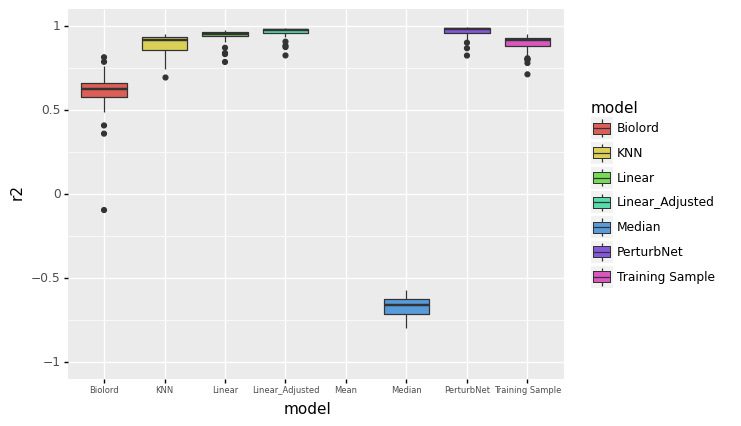

<ggplot: (1457905435201)>

In [32]:
from plotnine import ylim , theme, element_text
boxplot_metrics({"PerturbNet":results_PerturbNet, "Biolord":results_Biolord, "Training Sample":results_sample,
                "KNN": results_KNN, "Mean": results_mean, "Median":results_median, "Linear":results_linear, "Linear_Adjusted":
                results_linear_adjust}, metric_key = "r2") + ylim((-1, 1.0)) + theme(axis_text_x=element_text(size=6))

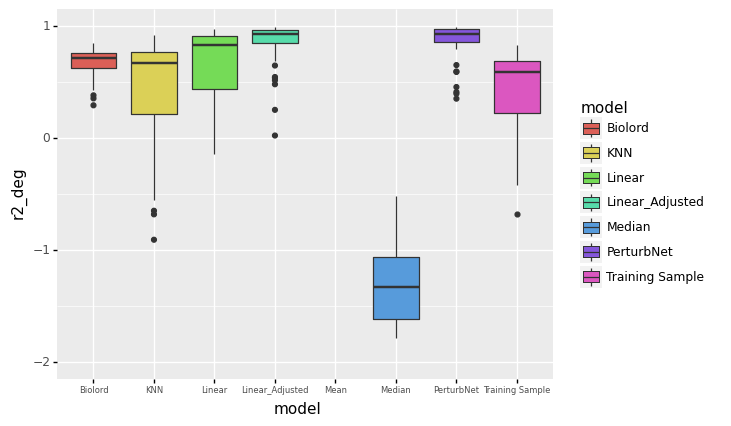

<ggplot: (1457737061741)>

In [33]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "Biolord":results_Biolord, "Training Sample":results_sample,
                "KNN": results_KNN, "Mean": results_mean, "Median":results_median, "Linear":results_linear, "Linear_Adjusted":
                results_linear_adjust}, metric_key = "r2_deg") + ylim((-2, 1.0)) + theme(axis_text_x=element_text(size=6))